# Classification of Online Retail Customers using Machine Learning Techniques

This notebook aims to analyse the purchases made by approximately 4,000 customers from a UK based online E-retail during the period of one year (from 01/12/2010 to 09/12/2011).

**Acknowledgement**: The data loading and preparation section has been adapted from Fabien Daniel's "[Customer Segmentation](https://www.kaggle.com/fabiendaniel/customer-segmentation)" notebook that is published on Kaggle.

**1. Loading and preparing the data**

**2. Recency, Frequency, and Monetary Value analysis**

**3. Data pre-processing for clustering**

**4. Customer Segmentation with K-means**

**5. Finding growth opportunities**

**6. Classification of customers**

## 0. Preliminary Settings

Before starting any analysis, we make sure that the basic and general-use libraries (numpy, pandas, etc.) are correctly imported.

We import the libraries including the Matplotlib-based statistical data visualization package "seaborn" to make graphs from our data.

In [1]:
# data upload
import pandas as pd
import io
# data manipulation and visualization
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
import datetime
import plotly.graph_objs as go
from plotly.offline import iplot
import nltk
nltk.download("punkt")
nltk.download('averaged_perceptron_tagger')
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib as mpl
from matplotlib import cm
from wordcloud import WordCloud
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
from sklearn.model_selection import learning_curve
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn import neighbors
from sklearn.svm import LinearSVC
import datetime as dt

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mohamed.a.eshra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mohamed.a.eshra\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## 1. Loading and preparing the data

We load the data into our environment.

In [2]:
xls="https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx"
sheet1 = pd.read_excel(xls, sheet_name='Year 2009-2010')
sheet2 = pd.read_excel(xls, sheet_name='Year 2010-2011')

# We append the two DataFrames
online = sheet1.append(sheet2, ignore_index=True)

# And we convert the data type of the InvoiceDate column to datetime
online['InvoiceDate'] = pd.to_datetime(online['InvoiceDate'])

# And we rename several columns
online.columns = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

We confirm that the dataset is appearing correctly.

In [3]:
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
online.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   InvoiceNo    1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   UnitPrice    1067371 non-null  float64       
 6   CustomerID   824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


And it's always a good practice to review data types.
As you can see, most of the columns are strings marked as objects.

Next, we review the data types, the number of null values and their percentage with respect to the total number of entries.

In [5]:
# We reveiew the data types and the number and percentage of null values
tab_info= pd.DataFrame(online.dtypes).T.rename(index={0:'column type'})
tab_info= tab_info.append(pd.DataFrame(online.isnull().sum()).T.rename(index={0:'number of null values'}))
tab_info= tab_info.append(pd.DataFrame(online.isnull().sum()/online.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
tab_info

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,float64,object
number of null values,0,0,4382,0,0,0,243007,0
null values (%),0.0,0.0,0.410541,0.0,0.0,0.0,22.766873,0.0


When looking at the number of null values in the dataframe, we note that almost 23% of the entries are not assigned to a particular customer. Since these entries are not useful in this case, we remove all null values from the dataframe and confirm that no null values are left in the dataframe.

In [6]:
online.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', online.shape)

# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(online.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(online.isnull().sum()).T.rename(index={0:'number of null values'}))
tab_info=tab_info.append(pd.DataFrame(online.isnull().sum()/online.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
tab_info

Dataframe dimensions: (824364, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,float64,object
number of null values,0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Finally, we check for duplicate entries and remove them.

In [7]:
print('Duplicate entries removed: {}'.format(online.duplicated().sum()))
online.drop_duplicates(inplace = True)

Duplicate entries removed: 26479


And we convert the data type of the CustomerID column to "object".

In [8]:
online = online.astype({"CustomerID": int})
online = online.astype({"CustomerID": object})

In [9]:
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


In [10]:
online.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797885 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    797885 non-null  object        
 1   StockCode    797885 non-null  object        
 2   Description  797885 non-null  object        
 3   Quantity     797885 non-null  int64         
 4   InvoiceDate  797885 non-null  datetime64[ns]
 5   UnitPrice    797885 non-null  float64       
 6   CustomerID   797885 non-null  object        
 7   Country      797885 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 54.8+ MB


And we see that after removing null values and duplicates we are left with almost 800K observations from the original dataframe to work with.

In [11]:
len(online)

797885

In [12]:
online['InvoiceNo']

0          489434
1          489434
2          489434
3          489434
4          489434
            ...  
1067366    581587
1067367    581587
1067368    581587
1067369    581587
1067370    581587
Name: InvoiceNo, Length: 797885, dtype: object

In [13]:
online['order_canceled'] = online['InvoiceNo'].astype(str).apply(lambda x:int('C' in x))
display(online[:15])

n1 = online['order_canceled'].sum()
n2 = online.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_canceled
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,0
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,0
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,0
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085,United Kingdom,0
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,0
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085,United Kingdom,0
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085,United Kingdom,0
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085,United Kingdom,0


Number of orders canceled: 18390/797885 (2.30%) 


In [14]:
online['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  online.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = online[(online['CustomerID'] == col['CustomerID']) &
                         (online['StockCode']  == col['StockCode']) & 
                         (online['InvoiceDate'] < col['InvoiceDate']) & 
                         (online['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        online.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            online.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break

In [15]:
print("entries_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entries: {}".format(len(doubtfull_entry)))

entries_to_remove: 16168
doubtfull_entries: 1942


In [16]:
online.drop(entry_to_remove, axis = 0, inplace = True)
online.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = online[(online['Quantity'] < 0) & (online['StockCode'] != 'D')]
print("number of cancelled entries that have not been deleted: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

number of cancelled entries that have not been deleted: 115


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_canceled,QuantityCanceled
9324,C490133,21314,SMALL GLASS HEART TRINKET POT,-504,2009-12-03 18:36:00,1.85,17949,United Kingdom,1,0
28066,C491728,22139,RETRO SPOT TEA SET CERAMIC 11 PC,-4,2009-12-14 09:18:00,4.95,12471,Germany,1,0
46326,C493689,79000,MOROCCAN TEA GLASS,-18,2010-01-05 12:45:00,0.85,14606,United Kingdom,1,0
47742,C493836,84050,PINK HEART SHAPE EGG FRYING PAN,-24,2010-01-07 13:49:00,1.65,12839,United Kingdom,1,0
69168,C495516,72739C,DARK CHOCOLATE SCENTCANDLE,-13,2010-01-25 14:26:00,1.25,13564,United Kingdom,1,0


In the final step of data preparation we remove the _StockCode_, _order_canceled_ and _QuantityCanceled_ since we don't need them anymore.

In [17]:
online.drop(['StockCode', 'order_canceled', 'QuantityCanceled'], axis = 1, inplace = True)

## 2. Recency, Frequency, and Monetary Value analysis

### 2.1 Calculate RFM values

Next, we will work on behavioral customer segmentation based on three metrics:

- Recency(R)

- Frequency(F)

- MonetaryValue(M)

First, we create a TotalSum column in the dataset by multiplying Quantity and UnitPrice 

In [18]:
# Create a TotalSum column in the dataset by multiplying Quantity and UnitPrice
online['TotalSum']= online['Quantity'] * online['UnitPrice']

Then, we create create a hypothetical snapshot_day variable as if we're doing analysis recently, that we can use to calculate recency.

In [19]:
snapshot_date = max(online.InvoiceDate) + datetime.timedelta(days=1)

Then, we calculate RFM values

In [20]:
# Calculate Recency, Frequency and Monetary value for each customer 
datamart = online.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})

# Rename the columns 
datamart.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'TotalSum': 'MonetaryValue'}, inplace=True)

# Print top 5 rows
print(datamart.head())

            Recency  Frequency  MonetaryValue
CustomerID                                   
12346           326         35       77555.46
12347             2        222        4921.53
12348            75         51        2019.40
12349            19        175        4428.69
12350           310         17         334.40


In [21]:
datamart.describe()

,Recency,Frequency,MonetaryValue
count,5881.000000,5881.000000,5881.000000
mean,201.351981,132.592246,2950.761843
std,209.473055,342.328531,14410.601354
min,1.000000,1.000000,0.000000
25%,26.000000,20.000000,341.900000
50%,96.000000,52.000000,865.600000
75%,380.000000,138.000000,2247.720000
max,739.000000,12438.000000,579758.620000


We have successfully built a dataset with recency, frequency, and monetary values.

### 2.2 Building RFM segments

#### 2.2.1 Calculate 3 groups for recency and frequency

We will now group the customers into three separate groups based on Recency, and Frequency.

We will use the result from this step in the next step, where we will group customers based on the MonetaryValue and finally calculate an RFM_Score.
Once completed, we print the results to the screen to make sure we have successfully created the quartile columns.

In [22]:
# Create labels for Recency and Frequency
r_labels = range(3, 0, -1); f_labels = range(1, 4)

# Assign these labels to three equal percentile groups 
r_groups = pd.qcut(datamart['Recency'], q=3, labels=r_labels)

# Assign these labels to three equal percentile groups 
f_groups = pd.qcut(datamart['Frequency'], q=3, labels=f_labels)

# Create new columns R and F 
datamart = datamart.assign(R=r_groups.values, F=f_groups.values)

# Create labels for MonetaryValue
m_labels = range(1, 4)

# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(datamart['MonetaryValue'], q=3, labels=m_labels)

# Create new column M
datamart = datamart.assign(M=m_groups.values)

datamart

,Recency,Frequency,MonetaryValue,R,F,M
CustomerID,,,,,,
12346,326,35,77555.46,1,2,3
12347,2,222,4921.53,3,3,3
12348,75,51,2019.40,2,2,3
12349,19,175,4428.69,3,3,3
12350,310,17,334.40,1,1,1
...,...,...,...,...,...,...
18283,4,938,2664.90,3,3,3
18284,432,28,461.68,1,1,2
18285,661,12,427.00,1,1,1


In the next step we will finalize the RFM segmentation by assigning customers to three groups based on the MonetaryValue percentiles and then calculate an RFM_Score which is a sum of the R, F, and M values.

In [23]:
# Calculate RFM_Score
datamart['RFM_Score'] = datamart[['R','F','M']].sum(axis=1)
print(datamart['RFM_Score'].head())

CustomerID
12346    6
12347    9
12348    7
12349    9
12350    3
Name: RFM_Score, dtype: int64


We have now built the critical components for RFM segmentation.

#### 2.2.2 Creating custom segments

Now we will  create a custom segmentation based on RFM_Score values. You will create a function to build segmentation and then assign it to each customer.

We create segments named Top, Middle, Low. If the RFM score is greater than or equal to 9, the level should be "Top". If it's between 6 and 9 it should be "Middle", and otherwise it should be "Low".

We will then apply the rfm_level function and store it as RFM_Level value.

In [24]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Top'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 9)):
        return 'Middle'
    else:
        return 'Low'

# Create a new variable RFM_Level
datamart['RFM_Level'] = datamart.apply(rfm_level, axis=1)

# Print the header with top 5 rows to the console
print(datamart.head(20))

            Recency  Frequency  MonetaryValue  R  F  M  RFM_Score RFM_Level
CustomerID                                                                 
12346           326         35       77555.46  1  2  3          6    Middle
12347             2        222        4921.53  3  3  3          9       Top
12348            75         51        2019.40  2  2  3          7    Middle
12349            19        175        4428.69  3  3  3          9       Top
12350           310         17         334.40  1  1  1          3       Low
12351           375         21         300.93  1  1  1          3       Low
12352            36        103        2849.84  3  3  3          9       Top
12353           204         24         406.76  2  1  1          4       Low
12354           232         58        1079.40  2  2  2          6    Middle
12355           214         35         947.61  2  2  2          6    Middle
12356            23        142        6371.73  3  3  3          9       Top
12357       

We have successfully created a custom segment based on RFM Score.

#### 2.2.3 Analyzing custom segments

As a final step, we will analyze average values of Recency, Frequency and MonetaryValue for the custom segments we've created.

We calculate the averages for Recency, Frequency and MonetaryValue for each _RFM_Level_ segment.

As the last column, we return the size of each segment passing count to the MonetaryValue column next to the mean.
We then print the aggregated dataset.

In [25]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = datamart.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
  
  # Return the size of each segment
    'MonetaryValue': ['mean', 'count']
}).round(1)

# Print the aggregated dataset
print(rfm_level_agg)

          Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Level                                      
Low         351.5      24.1         438.7  2580
Middle      112.4     120.4        2390.2  2335
Top          15.1     451.8       11014.9   966


## 3. Data pre-processing for clustering

### 3.1 Building RFM segments

After we have created segments, we want to make predictions. However, we first need to master practical data preparation methods to ensure our k-means clustering algorithm will uncover well-separated, sensible segments.

We will load the dataset with RFM values that we calculated previously as _datamart_rfm_ to explore the distributions of the RFM values.

In [26]:
# Load the dataset with RFM values that we calculated previously as datamart_rfm
datamart_rfm = datamart[['Recency', 'Frequency', 'MonetaryValue']]
datamart_rfm = datamart_rfm[datamart_rfm['MonetaryValue'] > 0]
datamart_rfm

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,326,35,77555.46
12347,2,222,4921.53
12348,75,51,2019.40
12349,19,175,4428.69
12350,310,17,334.40
...,...,...,...
18283,4,938,2664.90
18284,432,28,461.68
18285,661,12,427.00


The following is the distribution of the raw data.

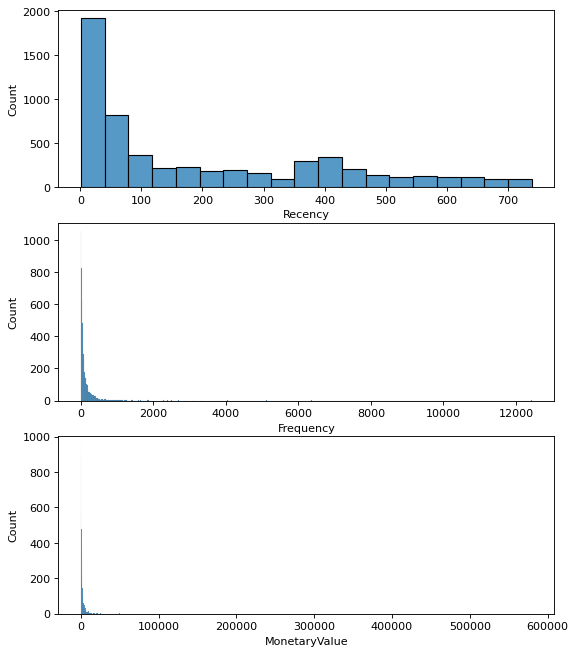

In [27]:
from matplotlib.pyplot import figure
figure(figsize=(8, 10), dpi=80)

# Plot recency distribution
plt.subplot(3, 1, 1); sns.histplot(datamart_rfm['Recency'])

# Plot frequency distribution
plt.subplot(3, 1, 2); sns.histplot(datamart_rfm['Frequency'])

# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.histplot(datamart_rfm['MonetaryValue'])

# Show the plot
plt.show()

We now have a good understanding about the distributions of RFM variables.

### 3.2 Pre-process RFM data

Since the variables are skewed and on different scales, we will now un-skew and normalize them.

We apply log transformation to unskew datamart_rfm and store it as datamart_log. Then, we initialize a StandardScaler() instance as scaler and fit it on the datamart_log data. 

Next, we transform the data by scaling and centering it with scaler.

Then, we create a pandas DataFrame from 'datamart_normalized' by adding index and column names from datamart_rfm.

In [28]:
datamart_rfm.describe() 

,Recency,Frequency,MonetaryValue
count,5878.000000,5878.000000,5878.000000
mean,201.226097,132.659408,2952.267846
std,209.337562,342.402978,14414.124682
min,1.000000,1.000000,2.950000
25%,26.000000,20.000000,342.280000
50%,96.000000,52.000000,867.740000
75%,380.000000,138.000000,2248.305000
max,739.000000,12438.000000,579758.620000


In [29]:
# Unskew the data
datamart_log = np.log(datamart_rfm)

# Initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(datamart_log)

# Scale and center the data
datamart_normalized = scaler.transform(datamart_log)

# Create a pandas DataFrame
datamart_normalized_df = pd.DataFrame(data=datamart_normalized, index=datamart_rfm.index, columns=datamart_rfm.columns)

In [30]:
datamart_normalized_df

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,0.843905,-0.258475,3.200581
12347,-2.267923,1.029145,1.215101
12348,-0.053773,0.003937,0.573656
12349,-0.892584,0.863331,1.139123
12350,0.813161,-0.761815,-0.721172
...,...,...,...
18283,-1.844472,2.033597,0.773377
18284,1.015894,-0.414010,-0.488928
18285,1.275731,-1.004590,-0.545156


In [31]:
datamart_log

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,5.786897,3.555348,11.258749
12347,0.693147,5.402677,8.501375
12348,4.317488,3.931826,7.610556
12349,2.944439,5.164786,8.395859
12350,5.736572,2.833213,5.812338
...,...,...,...
18283,1.386294,6.843750,7.887922
18284,6.068426,3.332205,6.134872
18285,6.493754,2.484907,6.056784


In [32]:
datamart_rfm

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,326,35,77555.46
12347,2,222,4921.53
12348,75,51,2019.40
12349,19,175,4428.69
12350,310,17,334.40
...,...,...,...
18283,4,938,2664.90
18284,432,28,461.68
18285,661,12,427.00


We have unskewed and normalized the dataset!

### 3.3 Visualize the normalized variables

Now we will plot the normalized and unskewed variables to see the difference in the distribution as well as the range of the values. 

The following is the distribution of the normalized data.

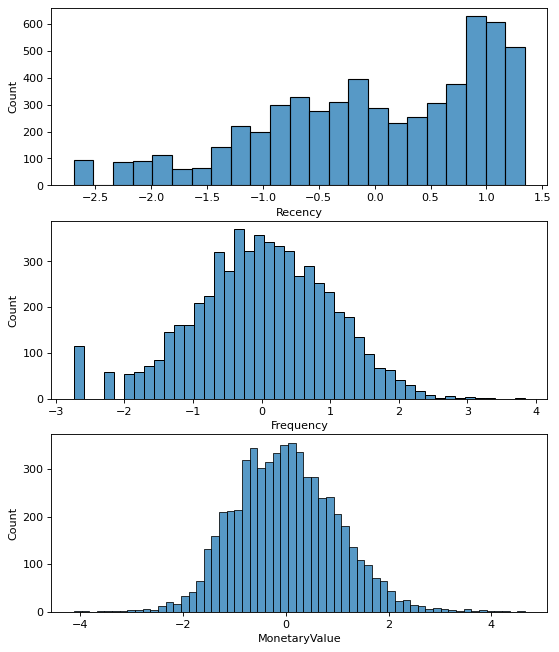

In [33]:
from matplotlib.pyplot import figure
figure(figsize=(8, 10), dpi=80)

# Plot recency distribution
plt.subplot(3, 1, 1); sns.histplot(datamart_normalized_df['Recency'])

# Plot frequency distribution
plt.subplot(3, 1, 2); sns.histplot(datamart_normalized_df['Frequency'])

# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.histplot(datamart_normalized_df['MonetaryValue'])

# Show the plot
plt.show()

We can see how the skewness is managed after applying these transformations.

### 3.4 Correlation of the normalized dataset

<AxesSubplot:>

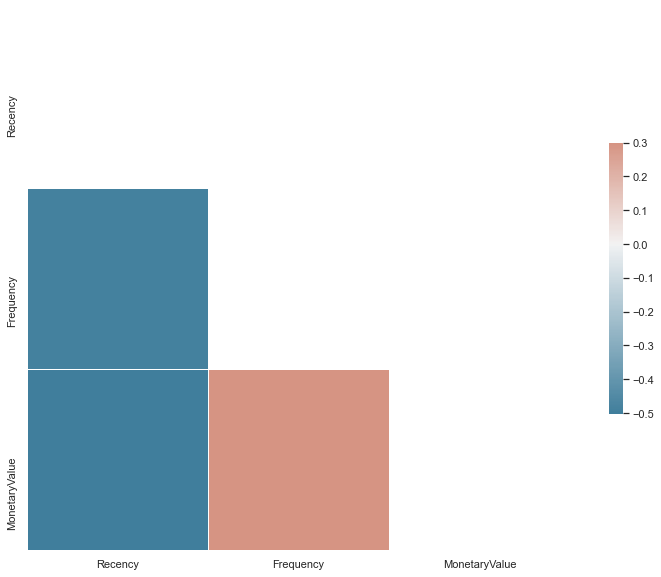

In [34]:
from string import ascii_letters

%matplotlib inline

sns.set_theme(style="white")

# Compute the correlation matrix
corr = datamart_normalized_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## 4. Customer Segmentation with K-means

### 4.1 Running k-means and assigning labels to raw data

In this section, we will use the data that we pre-processed in the previous section to identify customer clusters based on their recency, frequency, and monetary value.

In [35]:
datamart_normalized_df

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,0.843905,-0.258475,3.200581
12347,-2.267923,1.029145,1.215101
12348,-0.053773,0.003937,0.573656
12349,-0.892584,0.863331,1.139123
12350,0.813161,-0.761815,-0.721172
...,...,...,...
18283,-1.844472,2.033597,0.773377
18284,1.015894,-0.414010,-0.488928
18285,1.275731,-1.004590,-0.545156


We see that:
- More recent customers (low recency) tend to buy more frequently.
- Monetary value tend to be higher for more recent customers (low recency).
- Customers that buys more frequently tend to generate a higher monetary value.

### 4.2 Choosing the number of clusters

We will now calculate the sum of squared errors for different number of clusters ranging from 1 to 20.

In [36]:
# Fit KMeans and calculate SSE for each *k*
sse = {}

# Fit KMeans and calculate SSE for each k
for k in range(1, 11):
  
    # Initialize KMeans with k clusters and fit it on the normalized dataset
    kmeans = KMeans(n_clusters=k, random_state=1).fit(datamart_normalized)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

Now we will plot the sum of squared errors for each value of k and identify if there is an elbow. This will guide us towards the recommended number of clusters to use.

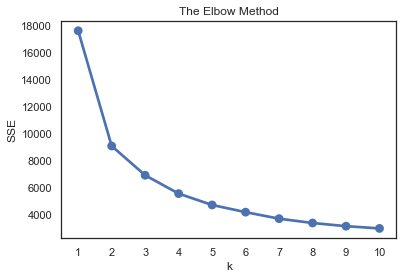

In [37]:
# Add the plot title "The Elbow Method"
plt.title('The Elbow Method')

# Add X-axis label "k"
plt.xlabel('k')

# Add Y-axis label "SSE"
plt.ylabel('SSE')

# Plot SSE values for each key in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

We can see the elbow is clearly around 3 clusters.

### 4.3 Building customer segments

We will now build 3 clusters with k-means clustering. We have loaded the pre-processed RFM dataset as datamart_normalized_df.

In [38]:
datamart_normalized= datamart_normalized_df.values

# Initialize KMeans
kmeans = KMeans(n_clusters=3, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(datamart_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_

In [39]:
datamart_rfm.shape

(5878, 3)

We have now built a 3-cluster segmentation and extracted cluster labels.

We will now analyse the average RFM values of the three clusters that we have created in the previous step.

In [40]:
# Create a DataFrame by adding a new cluster label column
datamart_rfm_k3 = datamart_rfm.assign(Cluster=cluster_labels)

# Group the data by cluster
grouped = datamart_rfm_k3.groupby(['Cluster'])

# Calculate average RFM values and segment sizes per cluster value
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          24.8     362.9        8705.8  1528
1         367.5      16.0         295.5  1896
2         182.6      79.4        1422.5  2454

In [41]:
datamart_rfm_k3

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12346,326,35,77555.46,0
12347,2,222,4921.53,0
12348,75,51,2019.40,2
12349,19,175,4428.69,0
12350,310,17,334.40,1
...,...,...,...,...
18283,4,938,2664.90,0
18284,432,28,461.68,1
18285,661,12,427.00,1


In [42]:
datamart_rfm_k3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5878 entries, 12346 to 18287
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Recency        5878 non-null   int64  
 1   Frequency      5878 non-null   int64  
 2   MonetaryValue  5878 non-null   float64
 3   Cluster        5878 non-null   int32  
dtypes: float64(1), int32(1), int64(2)
memory usage: 335.7 KB


We can now see the differences in RFM values of these segments.

### 4.4 Visualizing and evaluating the customer segments

Next, we visualize the customer segments, with the yellow cluster represting the "high" value customers.

<IPython.core.display.Javascript object>


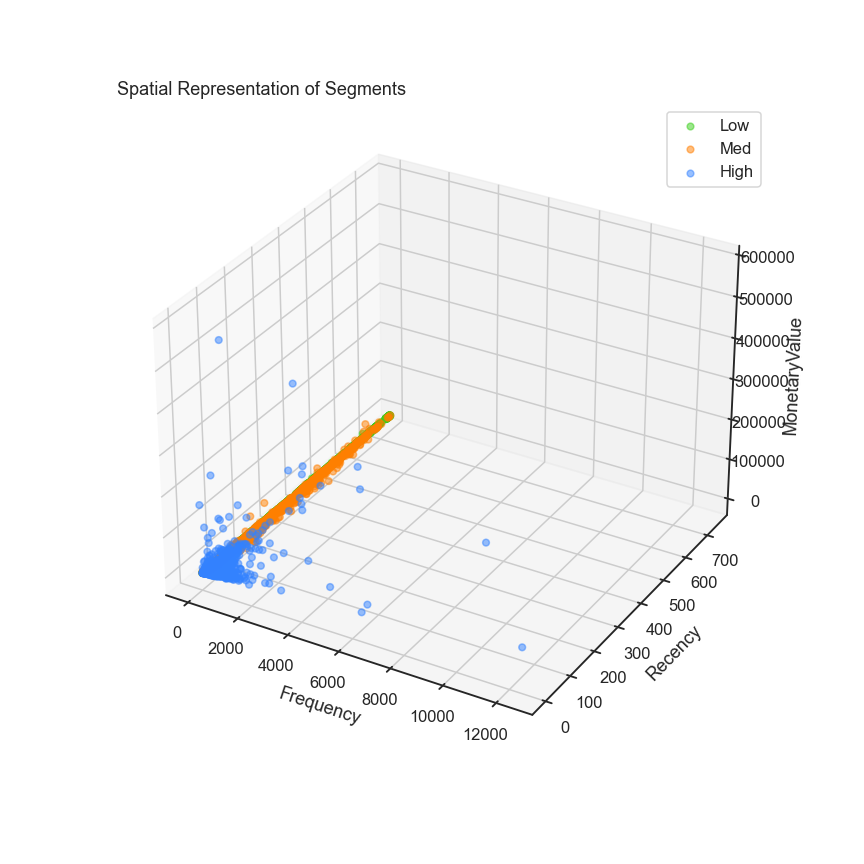

In [75]:
%matplotlib notebook

high = datamart_rfm_k3.query('Cluster == 0')
mid = datamart_rfm_k3.query('Cluster == 2')
low = datamart_rfm_k3.query('Cluster == 1')

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

g1= (low['Frequency'].values, low['Recency'].values, low['MonetaryValue'].values)
g2 = (mid['Frequency'].values, mid['Recency'].values, mid['MonetaryValue'].values)
g3= (high['Frequency'].values, high['Recency'].values, high['MonetaryValue'].values)

data = [g1, g2, g3]
colors = ['#3ACF1B', '#FF7F00', '#3382FF']
groups = ['Low', 'Med', 'High']

for data, color, group in zip(data, colors, groups):
    x, y, z = data
    ax.scatter(x, y, z, alpha=0.5, c=color, label=group)

# Make legend
    ax.legend()
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Recency')
    ax.set_zlabel('MonetaryValue')
    ax.set_title('Spatial Representation of Segments', loc='left')
    plt.show();

In [44]:
# Calculate Silhoutte Score
score = silhouette_score(datamart_normalized, kmeans.labels_, metric='euclidean').round(2)
score

0.31

# 5. Finding growth opportunities

### 5.1 Obtaining top product keywords for low-value customers

Next, we get to know our customers, analyze the customer segments and understand what kind of customer groups and behaviors they represent.
We will focus on the low-value customer segments (cluster number 1), which is the customer segment that has the highest recenecy, lowest frequency and monetary value to improve our marketing strategy and offer them products that are related to their shopping interests.

In [45]:
merged_df = pd.merge(online, datamart_rfm_k3, on='CustomerID')
merged_df = merged_df[['CustomerID', 'Country', 'Description', 'Cluster']].drop_duplicates()
merged_df.reset_index(drop=True, inplace = True)

low_value = merged_df[merged_df['Cluster'] == 1]
low_value.reset_index(drop=True, inplace = True)
low_value

,CustomerID,Country,Description,Cluster
0,12636,USA,POSTAGE,1
1,17592,United Kingdom,PINK SWEETHEART BRACELET,1
2,17592,United Kingdom,GREEN SWEETHEART BRACELET,1
3,17592,United Kingdom,PURPLE SWEETHEART BRACELET,1
4,17592,United Kingdom,BLUE SWEETHEART BRACELET,1
...,...,...,...,...
29110,12442,Spain,WRAP PAISLEY PARK,1
29111,12442,Spain,SET/10 RED POLKADOT PARTY CANDLES,1
29112,12442,Spain,POSTAGE,1
29113,13298,United Kingdom,KNITTED UNION FLAG HOT WATER BOTTLE,1


As a first step, we extract from the Description variable the information that will prove useful. To do this, we use the following function:

In [46]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, column = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[column]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; root = stemmer.stem(t)
            if root in keywords_roots:                
                keywords_roots[root].add(t)
                count_keywords[root] += 1                
            else:
                keywords_roots[root] = {t}
                count_keywords[root] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Number of keywords in variable '{}': {}".format(column,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

This function takes as input the dataframe and analyzes the content of the Description column by performing the following operations:

*   Extract the names (proper, common) appearing in the products description.
*   We extract the root of the word and aggregate the set of names associated with this particular root for each name.
*  Count the number of times each root appears in the dataframe.
*  When several words are listed for the same root, we consider that the keyword associated with this root is the shortest name (this systematically selects the singular when there are singular/plural variants).

The first step of the analysis is to retrieve the list of products from the "Description" variable:

In [47]:
df_products = pd.DataFrame(low_value['Description'].unique()).rename(columns = {0:'Description'})

Once this list is created, we use the function that we previously defined in order to analyze the description of the various products:

In [48]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_products)

Number of keywords in variable 'Description': 1469


The execution of this function returns three variables:

*   Keywords: the list of extracted keywords
*   Keywords_roots: a dictionary where the keys are the keywords' roots and the values are the lists of words associated with those roots
*   Count_keywords: dictionary listing the number of times every word is used

At this point, we convert the count_keywords dictionary into a list, to sort the keywords according to their occurences:

In [49]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

Using list_products, we create a representation of the most common keywords:

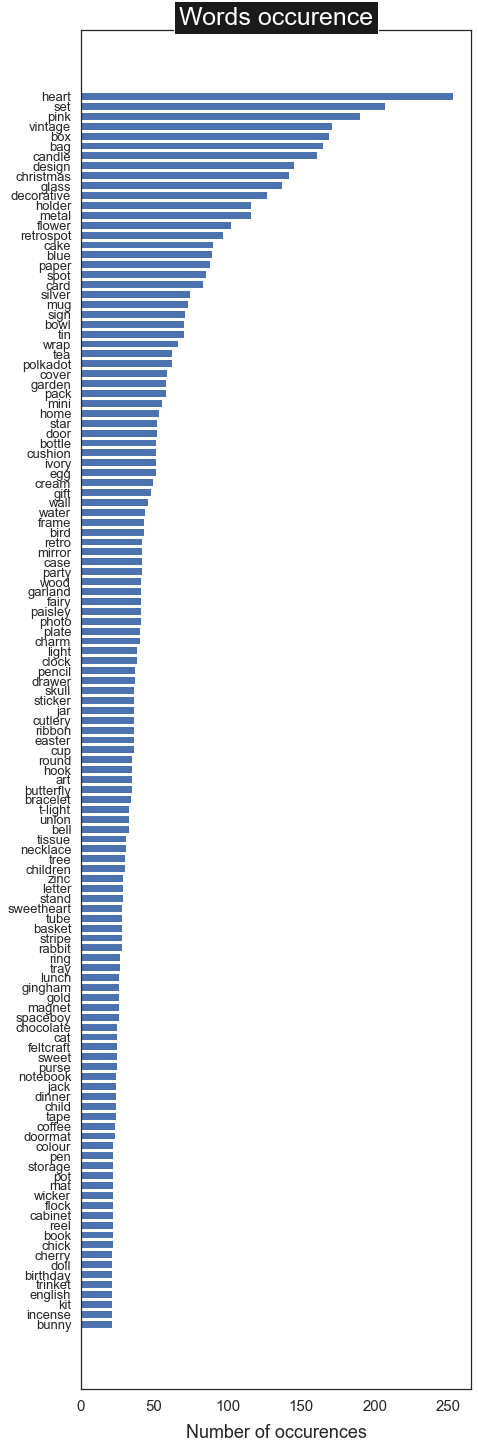

In [50]:
%matplotlib inline

list_words = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in list_words[:125]]
x_axis = [k for k,i in enumerate(list_words[:125])]
x_label = [i[0] for i in list_words[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Number of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

We see in the "Words occurance graph" that low-value customers' top 3 products contained the words "heart, "set", and "pink".
This information may be helpfull for improving marketing efforts directed to those customers.

### 5.2 Where are the low-value customers located?

In [51]:
temp = low_value[['CustomerID', 'Description', 'Country']].groupby(['CustomerID', 'Description', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('Number of countries in the dataframe: {}'.format(len(countries)))

Number of countries in the dataframe: 28


In [52]:
cust_temp= low_value[['CustomerID', 'Country']]
cust_grouped = cust_temp.groupby('CustomerID')

cust_country = cust_grouped.apply(lambda x: x['Country'].unique())

cust_country_df = pd.DataFrame({'CustomerID':cust_country.index, 'Country':cust_country.values})

# Remove square brackets from the "Country" column
cust_country_df['Country'] = cust_country_df['Country'].str[0]

cust_country_df

,CustomerID,Country
0,12350,Norway
1,12351,Unspecified
2,12353,Bahrain
3,12361,Belgium
4,12365,Cyprus
...,...,...
1891,18280,United Kingdom
1892,18281,United Kingdom
1893,18282,United Kingdom
1894,18284,United Kingdom


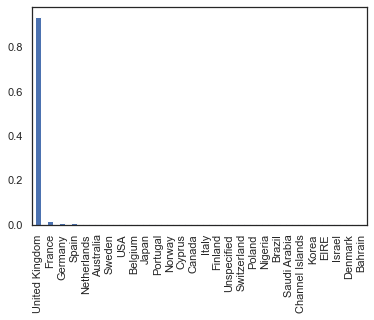

In [53]:
%matplotlib inline

cust_country_df['Country'].value_counts(normalize=True).plot.bar()

plt.show()

And we see that almost 100% of low-value customers are in the United Kingdom.

## 6. Classification of customers

In this section, the objective will be to train a classifier that will classify consumers in the different client categories that were established in the previous section.  We will test several classifiers implemented in scikit-learn. First, in order to simplify their use, we define a class that allows controling several of the functionalities common to these different classifiers:

In [54]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))

In [55]:
columns = ['Recency', 'Frequency', 'MonetaryValue']
X = datamart_rfm_k3[columns]
y = datamart_rfm_k3['Cluster']

We split the dataset into train, test and validation sets:

In [56]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=1111, stratify=y)

X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, test_size=0.25, random_state=1111, stratify=y_train) # 0.25 x 0.8 = 0.2

### 6.1 Support Vector Machine Classifier (SVC)

The first classifier that we use is the SVC classifier. In order to use it, we create an instance of LinearSVC.

In [57]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10), 'dual': [False]}], Kfold = 5)

svc.grid_fit(X = X_train, Y = y_train)

Then we test the quality of the prediction with respect to the test data:

In [58]:
svc.grid_predict(X_test, y_test)

Precision: 88.86 % 


#### 6.1.1 Confusion matrix

The accuracy of the results seems to be correct. Nevertheless, let us remember that when the different classes were defined, there was an imbalance in size between the classes obtained.

In particular, one class contains around 40% of the clients. It is therefore interesting to look at how the predictions and real values compare within the different clusters. 

This is the subject of the confusion matrices and to represent them, we use the code of [the sklearn documentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html):

In [59]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #_________________________________________________
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    #_________________________________________________
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

From which we create the following representation:

Confusion matrix, without normalization


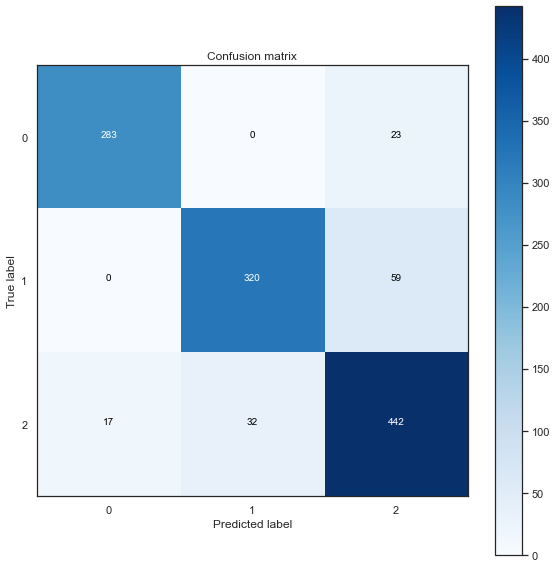

In [60]:
class_names = [i for i in range(3)]
cnf_matrix = confusion_matrix(y_test, svc.predictions) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

#### 6.1.2 Learning curve

A typical way to test the quality of a fit is to draw a learning curve. In particular, this type of curves allow to detect possible drawbacks in the model, linked for example to over- or under-fitting.

This also shows to which extent the model could benefit from a larger data sample. In order to draw this curve, we use the [scikit-learn documentation code again](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-%20self-examples-model-selection-pad-learning-curve-py).

In [61]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

### 6.2 Logistic Regression

We now consider the logistic regression classifier. As before, I create an instance of the Class_Fit class, adjust the model on the training data and see how the predictions compare to the real values:

In [62]:
lr = LogisticRegression(max_iter=20000, random_state= 1111)
lr = lr.fit(X_train, y_train)
lr.predict(X_test)
lr.score(X_test, y_test)

0.9260204081632653

In [63]:
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)
lr.grid_fit(X = X_train, Y = y_train)
lr.grid_predict(X_test, y_test)

c:\users\mohamed.a.eshra\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

c:\users\mohamed.a.eshra\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

c:\users\mohamed.a.eshra\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

c:\users\mohamed.a.eshra\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

c:\users\mohamed.a.eshra\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

c:\users\mohamed.a.eshra\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

c:\users\mohamed.a.eshra\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

c:\users\mohamed.a.eshra\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

c:\users\mohamed.a.eshra\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

c:\users\mohamed.a.eshra\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

c:\users\mohamed.a.eshra\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

c:\users\mohamed.a.eshra\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

Precision: 93.37 % 


c:\users\mohamed.a.eshra\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

c:\users\mohamed.a.eshra\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

### 6.3 k-Nearest Neighbors

In [64]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = y_train)
knn.grid_predict(X_test, y_test)

Precision: 90.14 % 


### 6.4 Decision Tree

In [65]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = y_train)
tr.grid_predict(X_test, y_test)

Precision: 93.62 % 


### 6.5 Random Forest

Precision: 97.11 % 


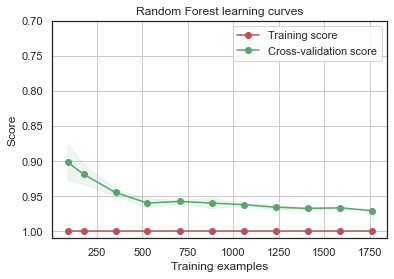

In [66]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 2)
rf.grid_fit(X = X_train, Y = y_train)
rf.grid_predict(X_test, y_test)

g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, y_train,
                        ylim = [1.01, 0.7], cv = 2, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 6.6 AdaBoost Classifier

Precision: 92.86 % 


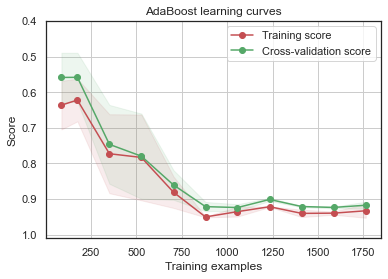

In [67]:
ada = Class_Fit(clf = AdaBoostClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters = param_grid, Kfold = 2)
ada.grid_fit(X = X_train, Y = y_train)
ada.grid_predict(X_test, y_test)

g = plot_learning_curve(ada.grid.best_estimator_, "AdaBoost learning curves", X_train, y_train,
                        ylim = [1.01, 0.4], cv = 2, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 6.7 Gradient Boosting Classifier

Precision: 97.19 % 


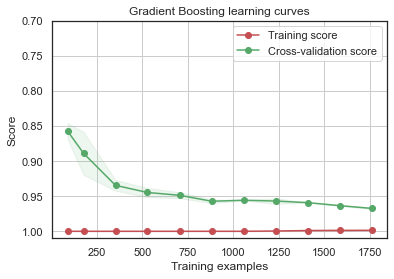

In [68]:
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 2)
gb.grid_fit(X = X_train, Y = y_train)
gb.grid_predict(X_test, y_test)

g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, y_train,
                        ylim = [1.01, 0.7], cv = 2, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 6.8 Voting Classifier

Finally, the results of the different classifiers presented in the previous sections can be combined to improve the classification model. This can be achieved by selecting the customer category as the one indicated by the majority of classifiers. To do this, we use the VotingClassifier method of the sklearn package. As a first step, we adjust the parameters of the various classifiers using the best parameters previously found:

In [69]:
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
svc_best = svm.LinearSVC(**svc.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

Then, we define a classifier that merges the results of the top three classifiers in terms of classification score, which in this case are Random Forest, Gradient Boosting and Logistic Regression:

In [70]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best),('lr', lr_best)], voting='soft') 

We train it:

In [71]:
votingC = votingC.fit(X_train, y_train)

c:\users\mohamed.a.eshra\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Finally, we create a prediction using this ensemble model:

In [72]:
predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(y_test, predictions)))

Precision: 97.11 % 


## 7. Testing predictions

Next, we test our model on the validation data.

In [73]:
classifiers = [(svc, 'Support Vector Machine'),
                (lr, 'Logistic Regression'),
                (knn, 'k-Nearest Neighbors'),
                (tr, 'Decision Tree'),
                (rf, 'Random Forest'),
                (gb, 'Gradient Boosting'),
                (ada, 'AdaBoost Classifier')]
#______________________________
for clf, label in classifiers:
    print(30*'_', '\n{}'.format(label))
    clf.grid_predict(X_val, y_val)

______________________________ 
Support Vector Machine
Precision: 91.33 % 
______________________________ 
Logistic Regression
Precision: 94.30 % 
______________________________ 
k-Nearest Neighbors
Precision: 92.09 % 
______________________________ 
Decision Tree
Precision: 95.49 % 
______________________________ 
Random Forest
Precision: 97.45 % 
______________________________ 
Gradient Boosting
Precision: 97.45 % 
______________________________ 
AdaBoost Classifier
Precision: 93.54 % 


Finally, as seen in Section 6.8, it is possible to improve the quality of the classifiers by combining their respective predictions using the ensemble classifier.

In [74]:
predictions = votingC.predict(X_val)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(y_val, predictions)))

predictions

Precision: 97.53 % 


array([0, 1, 1, ..., 1, 1, 2])